In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import sys

from reclab.environments import Topics
from reclab.environments import Engelhardt
from reclab.environments import LatentFactorBehavior
from reclab.recommenders import LibFM
from reclab.recommenders import KNNRecommender
from reclab.recommenders import TopPop
from reclab.recommenders import Autorec
from reclab.recommenders import Llorma

sys.path.append('experiments')
from run_utils import  run_env_experiment, plot_ratings_mses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Illustration of Different User Behaviors

In this notebook, for a fixed level of model and user behavior complexity, we illustrate the effect of different time-varying user behaviors on recommendation system quality. 
Specifically, we evaluate two metrics: observed ratings of recommended items, and predictive accuracy on recommended items. We may also want to look at diversity metrics, or those used in other papers.

In [3]:
## Key Parameters across all settings
expdirname = 'dynamic_user_static_rec'

topics = True

num_users = 100
num_items = 170
num_ratings = 1000
env_params = {
    'num_users': num_users,
    'num_items': num_itmes,
    'rating_frequency': 0.2,
    'num_init_ratings': num_ratings,
}

exp_params = {
    'n_trials': 10,
    'len_trial': 20,
    'SEED': 24532,
}
num_init_ratings = 1000

## Static User Behavior

Here, the user model does not change over time.

In [19]:
if topics:
    params = {'num_topics': 10}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'static_2'+env.name+'.npz'

recommenders = [
    Llorma(max_user=num_users,
           max_item=num_items
    ),
    LibFM(
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        max_num_users=num_users,
        max_num_items=num_items,
        method='sgd',
        learning_rate=0.01
    ),
    LibFM(
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        max_num_users=num_users,
        max_num_items=num_items,
        method='sgd',
        learning_rate=0.1
    ),
    Autorec(
        num_users=num_users,
        num_items=num_items,
        hidden_neuron=500,
        base_lr=1e-2,
        train_epoch=50
    ),
    KNNRecommender(
        user_based=True
    ),
    KNNRecommender(
        user_based=False
    ),
] 

recommenders = recommenders = [
    Llorma(max_user=num_users,
           max_item=num_items,
           train_steps=20,
           use_cache=False),
    Llorma(max_user=num_users,
           max_item=num_items,
           train_steps=20,
           use_cache=True),]
#env = Fixed

ratings, preds, dense_ratings, dense_preds = run_env_experiment([env], recommenders, [1,2,3], 
                                                                100, bucket_name=None,
                                                                data_dir ='llorma',
                                                                recommender_names=['lorma-no-cache', 'llorma-use-cache'],
                                                                overwrite=False)

Started experiments on environment: topics_0
Running trials for recommender: lorma-no-cache
Running trial with seed: 1
INFO:tensorflow:Restoring parameters from results/model-906741.ckpt


HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.662, Mean: 3.002, High: 3.279
Low: 2.677, Mean: 3.015, High: 3.371
INFO:tensorflow:Restoring parameters from results/model-321332.ckpt
Low: 2.713, Mean: 3.013, High: 3.323
Low: 2.663, Mean: 3.016, High: 3.384
INFO:tensorflow:Restoring parameters from results/model-3760.ckpt
Low: 2.498, Mean: 2.814, High: 3.180
Low: 2.644, Mean: 2.993, High: 3.379
INFO:tensorflow:Restoring parameters from results/model-844334.ckpt
Low: 2.675, Mean: 2.962, High: 3.298
Low: 2.636, Mean: 2.990, High: 3.377
INFO:tensorflow:Restoring parameters from results/model-659247.ckpt
Low: 2.636, Mean: 3.043, High: 3.369
Low: 2.617, Mean: 2.981, High: 3.369
INFO:tensorflow:Restoring parameters from results/model-445961.ckpt
Low: 2.781, Mean: 3.197, High: 3.507
Low: 2.625, Mean: 2.988, High: 3.378
INFO:tensorflow:Restoring parameters from results/model-558153.ckpt
Low: 2.697, Mean: 3.059, High: 3.461
Low: 2.638, Mean: 2.987, High: 3.371
INFO:tensorflow:Restoring parameters from results/model-608901.ckpt
Low: 2.6

Low: 2.303, Mean: 2.916, High: 3.307
Low: 2.457, Mean: 2.918, High: 3.334
INFO:tensorflow:Restoring parameters from results/model-96005.ckpt
Low: 2.253, Mean: 2.656, High: 3.156
Low: 2.436, Mean: 2.912, High: 3.334
INFO:tensorflow:Restoring parameters from results/model-610925.ckpt
Low: 2.499, Mean: 2.816, High: 3.207
Low: 2.446, Mean: 2.924, High: 3.338
INFO:tensorflow:Restoring parameters from results/model-734361.ckpt
Low: 2.401, Mean: 2.801, High: 3.374
Low: 2.441, Mean: 2.915, High: 3.331
INFO:tensorflow:Restoring parameters from results/model-103997.ckpt
Low: 2.533, Mean: 3.036, High: 3.369
Low: 2.456, Mean: 2.925, High: 3.337
INFO:tensorflow:Restoring parameters from results/model-6336.ckpt
Low: 2.542, Mean: 2.988, High: 3.312
Low: 2.455, Mean: 2.925, High: 3.325
INFO:tensorflow:Restoring parameters from results/model-176890.ckpt
Low: 2.382, Mean: 2.839, High: 3.176
Low: 2.466, Mean: 2.922, High: 3.337
INFO:tensorflow:Restoring parameters from results/model-703046.ckpt
Low: 2.43

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.779, Mean: 3.106, High: 3.474
Low: 2.668, Mean: 3.013, High: 3.376
INFO:tensorflow:Restoring parameters from results/model-121035.ckpt
Low: 2.534, Mean: 2.857, High: 3.211
Low: 2.655, Mean: 3.001, High: 3.370
INFO:tensorflow:Restoring parameters from results/model-993464.ckpt
Low: 2.679, Mean: 3.031, High: 3.390
Low: 2.660, Mean: 3.005, High: 3.373
INFO:tensorflow:Restoring parameters from results/model-948767.ckpt
Low: 2.735, Mean: 2.990, High: 3.241
Low: 2.654, Mean: 3.010, High: 3.375
INFO:tensorflow:Restoring parameters from results/model-624929.ckpt
Low: 2.772, Mean: 3.120, High: 3.516
Low: 2.642, Mean: 2.996, High: 3.376
INFO:tensorflow:Restoring parameters from results/model-502891.ckpt
Low: 2.665, Mean: 2.962, High: 3.282
Low: 2.641, Mean: 2.986, High: 3.362
INFO:tensorflow:Restoring parameters from results/model-555068.ckpt
Low: 2.808, Mean: 3.070, High: 3.358
Low: 2.630, Mean: 2.984, High: 3.363
INFO:tensorflow:Restoring parameters from results/model-180406.ckpt
Low: 2

Low: 2.260, Mean: 2.723, High: 3.210
Low: 2.459, Mean: 2.921, High: 3.347
INFO:tensorflow:Restoring parameters from results/model-993003.ckpt
Low: 2.324, Mean: 2.725, High: 3.149
Low: 2.453, Mean: 2.923, High: 3.347
INFO:tensorflow:Restoring parameters from results/model-251344.ckpt
Low: 2.631, Mean: 3.065, High: 3.337
Low: 2.443, Mean: 2.930, High: 3.357
INFO:tensorflow:Restoring parameters from results/model-444590.ckpt
Low: 2.299, Mean: 2.994, High: 3.407
Low: 2.438, Mean: 2.922, High: 3.354
INFO:tensorflow:Restoring parameters from results/model-56212.ckpt
Low: 2.313, Mean: 2.665, High: 3.109
Low: 2.437, Mean: 2.918, High: 3.364
INFO:tensorflow:Restoring parameters from results/model-43432.ckpt
Low: 2.530, Mean: 2.948, High: 3.275
Low: 2.440, Mean: 2.918, High: 3.347
INFO:tensorflow:Restoring parameters from results/model-395962.ckpt
Low: 2.630, Mean: 3.110, High: 3.490
Low: 2.425, Mean: 2.935, High: 3.374
INFO:tensorflow:Restoring parameters from results/model-661576.ckpt
Low: 2.3

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.541, Mean: 2.912, High: 3.308
Low: 2.665, Mean: 3.015, High: 3.384
INFO:tensorflow:Restoring parameters from results/model-278640.ckpt
Low: 2.792, Mean: 3.259, High: 3.647
Low: 2.659, Mean: 3.020, High: 3.388
INFO:tensorflow:Restoring parameters from results/model-757233.ckpt
Low: 2.559, Mean: 2.874, High: 3.216
Low: 2.639, Mean: 3.008, High: 3.377
INFO:tensorflow:Restoring parameters from results/model-191233.ckpt
Low: 2.930, Mean: 3.216, High: 3.509
Low: 2.648, Mean: 3.012, High: 3.370
INFO:tensorflow:Restoring parameters from results/model-188262.ckpt
Low: 2.592, Mean: 2.912, High: 3.390
Low: 2.640, Mean: 2.997, High: 3.353
INFO:tensorflow:Restoring parameters from results/model-30358.ckpt
Low: 2.554, Mean: 2.924, High: 3.359
Low: 2.629, Mean: 3.004, High: 3.378
INFO:tensorflow:Restoring parameters from results/model-136888.ckpt
Low: 2.623, Mean: 3.024, High: 3.396
Low: 2.630, Mean: 2.989, High: 3.357
INFO:tensorflow:Restoring parameters from results/model-776328.ckpt
Low: 2.

Low: 2.436, Mean: 2.978, High: 3.424
Low: 2.517, Mean: 2.911, High: 3.318
INFO:tensorflow:Restoring parameters from results/model-220232.ckpt
Low: 2.433, Mean: 2.744, High: 3.305
Low: 2.516, Mean: 2.910, High: 3.311
INFO:tensorflow:Restoring parameters from results/model-218888.ckpt
Low: 2.313, Mean: 2.819, High: 3.401
Low: 2.499, Mean: 2.900, High: 3.313
INFO:tensorflow:Restoring parameters from results/model-598456.ckpt
Low: 2.506, Mean: 2.871, High: 3.376
Low: 2.514, Mean: 2.907, High: 3.316
INFO:tensorflow:Restoring parameters from results/model-106834.ckpt
Low: 2.427, Mean: 2.668, High: 2.898
Low: 2.499, Mean: 2.902, High: 3.316
INFO:tensorflow:Restoring parameters from results/model-210332.ckpt
Low: 2.421, Mean: 2.723, High: 3.091
Low: 2.502, Mean: 2.895, High: 3.316
INFO:tensorflow:Restoring parameters from results/model-963864.ckpt
Low: 2.579, Mean: 2.998, High: 3.377
Low: 2.493, Mean: 2.899, High: 3.327
INFO:tensorflow:Restoring parameters from results/model-642895.ckpt
Low: 2

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.665, Mean: 3.006, High: 3.301
Low: 2.666, Mean: 3.010, High: 3.375
Low: 2.727, Mean: 3.010, High: 3.326
Low: 2.652, Mean: 3.002, High: 3.375
Low: 2.493, Mean: 2.812, High: 3.144
Low: 2.647, Mean: 2.989, High: 3.380
Low: 2.741, Mean: 3.014, High: 3.322
Low: 2.636, Mean: 2.989, High: 3.367
Low: 2.692, Mean: 3.061, High: 3.379
Low: 2.641, Mean: 2.985, High: 3.362
Low: 2.712, Mean: 3.100, High: 3.443
Low: 2.632, Mean: 2.980, High: 3.365
Low: 2.619, Mean: 2.965, High: 3.383
Low: 2.622, Mean: 2.974, High: 3.361
Low: 2.552, Mean: 2.902, High: 3.343
Low: 2.617, Mean: 2.977, High: 3.361
Low: 2.670, Mean: 3.007, High: 3.363
Low: 2.608, Mean: 2.965, High: 3.362
Low: 2.779, Mean: 3.146, High: 3.491
Low: 2.591, Mean: 2.957, High: 3.359
Low: 2.540, Mean: 2.842, High: 3.243
Low: 2.592, Mean: 2.958, High: 3.361
Low: 2.661, Mean: 2.981, High: 3.298
Low: 2.587, Mean: 2.951, High: 3.353
Low: 2.570, Mean: 2.899, High: 3.247
Low: 2.589, Mean: 2.953, High: 3.361
Low: 2.380, Mean: 2.678, High: 3.335
L

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.786, Mean: 3.115, High: 3.483
Low: 2.667, Mean: 3.011, High: 3.373
Low: 2.540, Mean: 2.860, High: 3.235
Low: 2.657, Mean: 3.005, High: 3.363
Low: 2.663, Mean: 2.982, High: 3.355
Low: 2.661, Mean: 3.002, High: 3.359
Low: 2.762, Mean: 3.001, High: 3.245
Low: 2.658, Mean: 2.992, High: 3.353
Low: 2.780, Mean: 3.085, High: 3.463
Low: 2.651, Mean: 2.984, High: 3.351
Low: 2.663, Mean: 2.961, High: 3.301
Low: 2.652, Mean: 2.992, High: 3.360
Low: 2.795, Mean: 3.075, High: 3.375
Low: 2.648, Mean: 2.991, High: 3.373
Low: 2.518, Mean: 2.788, High: 3.109
Low: 2.640, Mean: 2.993, High: 3.366
Low: 2.560, Mean: 2.831, High: 3.185
Low: 2.630, Mean: 2.982, High: 3.364
Low: 2.591, Mean: 2.897, High: 3.261
Low: 2.627, Mean: 2.978, High: 3.353
Low: 2.533, Mean: 2.877, High: 3.355
Low: 2.620, Mean: 2.984, High: 3.354
Low: 2.662, Mean: 3.017, High: 3.343
Low: 2.612, Mean: 2.975, High: 3.358
Low: 2.613, Mean: 2.940, High: 3.354
Low: 2.615, Mean: 2.971, High: 3.356
Low: 2.435, Mean: 2.756, High: 3.173
L

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

Low: 2.561, Mean: 2.902, High: 3.275
Low: 2.666, Mean: 3.004, High: 3.367
Low: 2.787, Mean: 3.237, High: 3.670
Low: 2.658, Mean: 3.012, High: 3.376
Low: 2.578, Mean: 2.878, High: 3.244
Low: 2.647, Mean: 3.002, High: 3.375
Low: 2.914, Mean: 3.211, High: 3.515
Low: 2.645, Mean: 3.006, High: 3.369
Low: 2.603, Mean: 2.941, High: 3.404
Low: 2.641, Mean: 2.989, High: 3.357
Low: 2.584, Mean: 2.912, High: 3.252
Low: 2.631, Mean: 2.994, High: 3.356
Low: 2.621, Mean: 3.042, High: 3.420
Low: 2.623, Mean: 2.985, High: 3.360
Low: 2.674, Mean: 3.127, High: 3.451
Low: 2.620, Mean: 2.989, High: 3.365
Low: 2.655, Mean: 2.999, High: 3.394
Low: 2.618, Mean: 2.977, High: 3.358
Low: 2.738, Mean: 3.049, High: 3.375
Low: 2.604, Mean: 2.981, High: 3.365
Low: 2.601, Mean: 2.949, High: 3.280
Low: 2.618, Mean: 2.984, High: 3.355
Low: 2.613, Mean: 2.962, High: 3.312
Low: 2.615, Mean: 2.977, High: 3.344
Low: 2.583, Mean: 2.969, High: 3.370
Low: 2.601, Mean: 2.968, High: 3.353
Low: 2.572, Mean: 2.860, High: 3.207
L

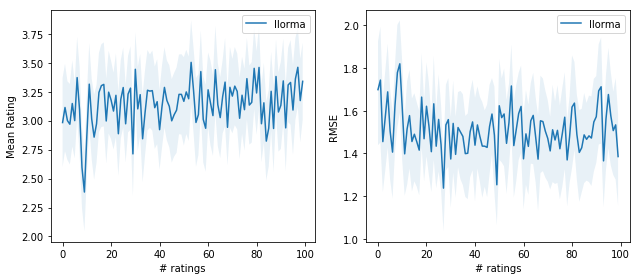

In [21]:
plot_ratings_mses(ratings[0], preds[0], ['llorma'])

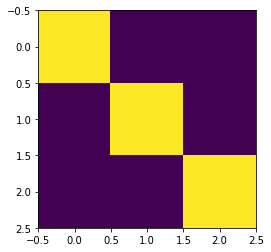

In [11]:
m = np.eye(3)
plt.imshow(m)
plt.show()

## Partially Hidden User Behavior

Here, there is a portion of item utility that is unknown to a user until the item is consumed. From the paper "How Algorithmic Confounding in Recommendation Systems
Increases Homogeneity and Decreases Utility".

In [0]:
if topics:
    params = {'num_topics': 10}
    env = Engelhardt(**params, **env_params)

    datafilename = env.name+'.npz'
    ratings, preds = run_env_experiment([env], recommenders, 10, 200, 
                                        expdirname, datafilename, overwrite=True)

In [0]:
plot_ratings_mses(ratings[0], preds[0], num_init_ratings, ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## User Interests Shift with Exposure

Here, the underlying user interest changes over time to match the body of items that have been recommended.

In [0]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'increasing_interest_'+env.name+'.npz'
ratings, preds = run_env_experiment([env], recommenders, 10, 200, 
                                    expdirname, datafilename, overwrite=True)

In [0]:
plot_ratings_mses(ratings[0], preds[0], num_init_ratings, ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## User Gets Bored

Here, user interest decreases for items too similar to those that they have recently been exposed to, with some decay in the effect.

In [0]:
if topics:
    params = {'num_topics': 10, 'memory_length': 5, 'boredom_threshold': 2, 
              'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'memory_length': 5, 'boredom_threshold': 0.5, 
              'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_'+env.name+'.npz'
ratings, preds = run_env_experiment([env], recommenders, 10, 200, 
                                    expdirname, datafilename, overwrite=True)

In [0]:
plot_ratings_mses(ratings[0], preds[0], num_init_ratings, ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])

## User Interests Shift, also Gets Bored

This is a combination of the previous two cases, where users gradually become more interested in topics that they are exposed to, but also exhibit boredom when they see many similar items in a row.

In [0]:
if topics:
    params = {'num_topics': 10, 'topic_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 2, 'boredom_penalty': 1.0}
    env = Topics(**params, **env_params)
else:
    params = {'latent_dim': 8, 'affinity_change': 0.1, 'memory_length': 5, 
              'boredom_threshold': 0.5, 'boredom_penalty': 1.0}
    env = LatentFactorBehavior(**params, **env_params)
datafilename = 'boredom_and_interest_'+env.name+'.npz'
ratings, preds = run_env_experiment([env], recommenders, 10, 200, 
                                    expdirname, datafilename, overwrite=True)

In [0]:
plot_ratings_mses(ratings[0], preds[0], num_init_ratings, ['libfm (lr=0.01)', 'libfm(lr=0.1)', 'autorec', 'userKnn', 'itemKnn'])